In [ ]:
# %conda install -c pytorch faiss-cpu
%conda install -c conda-forge faiss-gpu

In [ ]:
%conda install -c "conda-forge/label/broken" faiss-gpu

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px
import faiss
import sweetviz as sv
import numpy as np
from sklearn.preprocessing import RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
train = pd.read_csv('./Data/train.csv', index_col=0)
valid = pd.read_csv('./Data/validation.csv', index_col=0)
valid_awr = pd.read_csv('./Data/validation_answer.csv', index_col=0)
base = pd.read_csv('./Data/base.csv', index_col=0)

In [3]:
train.describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
    .background_gradient(subset=['std'], cmap='Blues')\
    .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
0,100000.000000,-85.328679,25.803845,-186.280270,-103.309147,-85.273695,-67.330810,14.585236
1,100000.000000,7.664345,4.955651,-11.560507,4.313784,7.652854,10.981191,28.917845
2,100000.000000,-43.667046,39.111064,-224.896060,-69.494487,-42.830246,-17.713690,128.108460
3,100000.000000,-146.118630,20.434841,-223.307220,-160.028520,-146.067445,-132.277745,-60.751625
4,100000.000000,111.770592,47.700958,-93.272020,79.474322,112.260100,143.760830,301.363600
5,100000.000000,-73.178792,28.718853,-184.962450,-92.834080,-73.364420,-53.699612,51.849710
6,100000.000000,-440.615118,279.017550,-791.469482,-738.536868,-511.837758,-201.116578,109.625188
7,100000.000000,21.231588,65.985214,-278.582820,-22.131764,22.278989,65.899595,288.171840
8,100000.000000,123.067891,6.492081,94.831150,118.674642,123.087540,127.541802,149.356200
9,100000.000000,126.120201,64.912752,-142.156950,82.545028,125.963340,169.701005,392.827150


In [4]:
base.describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
    .background_gradient(subset=['std'], cmap='Blues')\
    .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
0,2918139.000000,-86.229474,24.891320,-199.468700,-103.065438,-86.231500,-69.256577,21.515549
1,2918139.000000,8.080077,4.953387,-13.914608,4.708491,8.038950,11.470066,29.937210
2,2918139.000000,-44.580804,38.631660,-240.073400,-69.559490,-43.816605,-19.625266,160.937230
3,2918139.000000,-146.634991,19.844805,-232.667140,-159.905060,-146.776810,-133.327655,-51.374780
4,2918139.000000,111.316628,46.348090,-105.582960,80.507945,111.873000,142.374275,319.664500
5,2918139.000000,-71.991376,28.186068,-211.008600,-91.379940,-71.922300,-52.441105,58.806244
6,2918139.000000,-392.223854,271.654995,-791.469870,-629.331823,-422.201616,-156.668583,109.632533
7,2918139.000000,20.352829,64.216382,-301.859740,-22.221474,20.804773,63.918212,341.228200
8,2918139.000000,123.684234,6.356109,93.153046,119.483983,123.892250,127.970480,152.261200
9,2918139.000000,124.458053,64.430576,-173.871950,81.767510,123.497696,167.220605,427.542050


In [5]:
# train_report = sv.analyze(train)

In [6]:
# train_report.show_html('Train_report.html')

In [7]:
d = base.shape[1]
d

72

In [8]:
features_t = train.drop('Target', axis=1)

In [9]:
ngpu = 2

## L2

In [10]:
index = faiss.IndexFlatL2(d)
index.add(base)

In [11]:
resources = [faiss.StandardGpuResources() for i in range(ngpu)]
index_gpu = faiss.index_cpu_to_gpu_multiple_py(resources, index)

In [12]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}

In [13]:
targets = train["Target"]

In [14]:
targets_v = valid_awr['Expected']

In [15]:
%%time
D, I = index_gpu.search(features_t, 5)
acc = 0
for target, el in zip(targets.values.tolist(), I.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(I))

13.804
CPU times: total: 2.22 s
Wall time: 2.84 s


In [16]:
%%time
D, I = index_gpu.search(valid, 5)
acc = 0
for target, el in zip(targets_v.values.tolist(), I.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(I))

13.286
CPU times: total: 1.92 s
Wall time: 2.88 s


## IVF

In [17]:
nlist = 288

quant = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quant, d, nlist)
index.train(base)
index.add(base)
index.nprobe = 16
resources = [faiss.StandardGpuResources() for i in range(ngpu)]
index_gpu = faiss.index_cpu_to_gpu_multiple_py(resources, index)

In [18]:
%%time
D, I = index_gpu.search(features_t, 5)
acc = 0
for target, el in zip(targets.values.tolist(), I.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(I))

13.756
CPU times: total: 8.3 s
Wall time: 20.8 s


In [19]:
%%time
D, I = index_gpu.search(valid, 5)
acc = 0
for target, el in zip(targets_v.values.tolist(), I.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(I))

13.262
CPU times: total: 22.8 s
Wall time: 20.4 s


## Features tuning

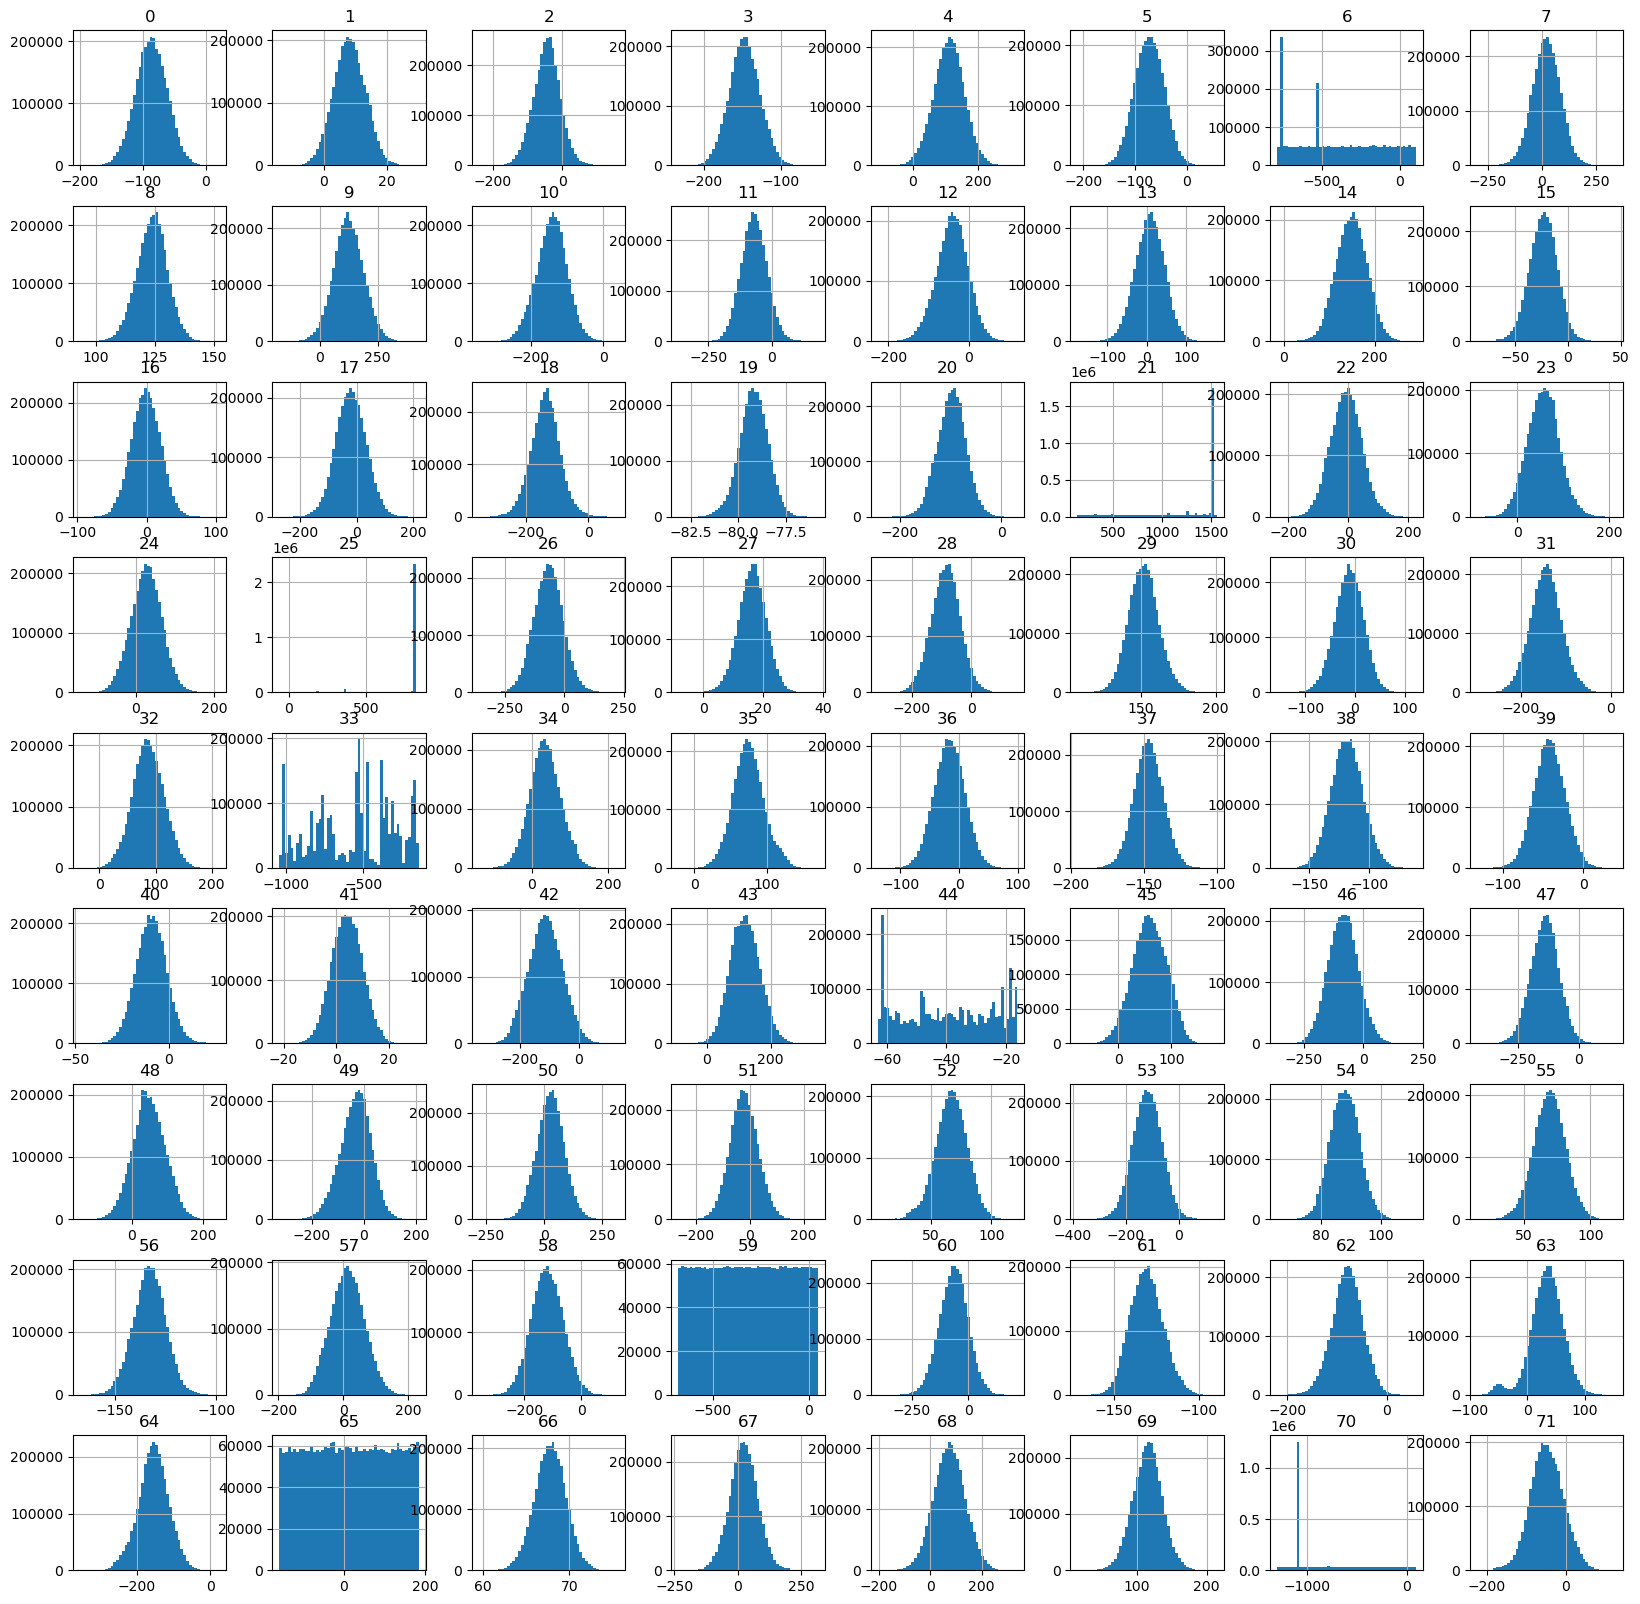

In [20]:
base.hist(figsize=[20, 20], bins=50);

In [34]:
base_norm = base.drop(['6','21','25','33','44','59','65','70'], axis=1)
train_norm = train.drop(['6','21','25','33','44','59','65','70'], axis=1)
valid_norm = valid.drop(['6','21','25','33','44','59','65','70'], axis=1)

In [35]:
features_t_norm = train_norm.drop('Target', axis=1)

In [36]:
vif_data = pd.DataFrame()
vif_data["feature"] = features_t_norm.columns

# вычисление VIF для каждого признака
vif_data["VIF"] = [variance_inflation_factor(features_t_norm.values, i)
                          for i in range(len(features_t_norm.columns))]
  
print(vif_data)

   feature          VIF
0        0    12.133567
1        1     3.441980
2        2     2.278512
3        3    52.551247
4        4     6.613623
..     ...          ...
59      66  1258.061148
60      67     1.191164
61      68     2.430367
62      69    29.843319
63      71     2.426434

[64 rows x 2 columns]


In [82]:
VIF_features_drop = vif_data.query('VIF >= 9.0')['feature']
VIF_features_drop

0      0
3      3
7      8
9     10
13    14
17    18
18    19
19    20
24    27
26    29
28    31
29    32
31    35
33    37
34    38
47    52
49    54
50    55
51    56
55    61
58    64
59    66
62    69
Name: feature, dtype: object

In [83]:
base_vif = base_norm.drop(VIF_features_drop.values, axis=1)
train_vif = train_norm.drop(VIF_features_drop.values, axis=1)
valid_vif = valid_norm.drop(VIF_features_drop.values, axis=1)

In [84]:
features_t_vif = train_vif.drop('Target', axis=1)

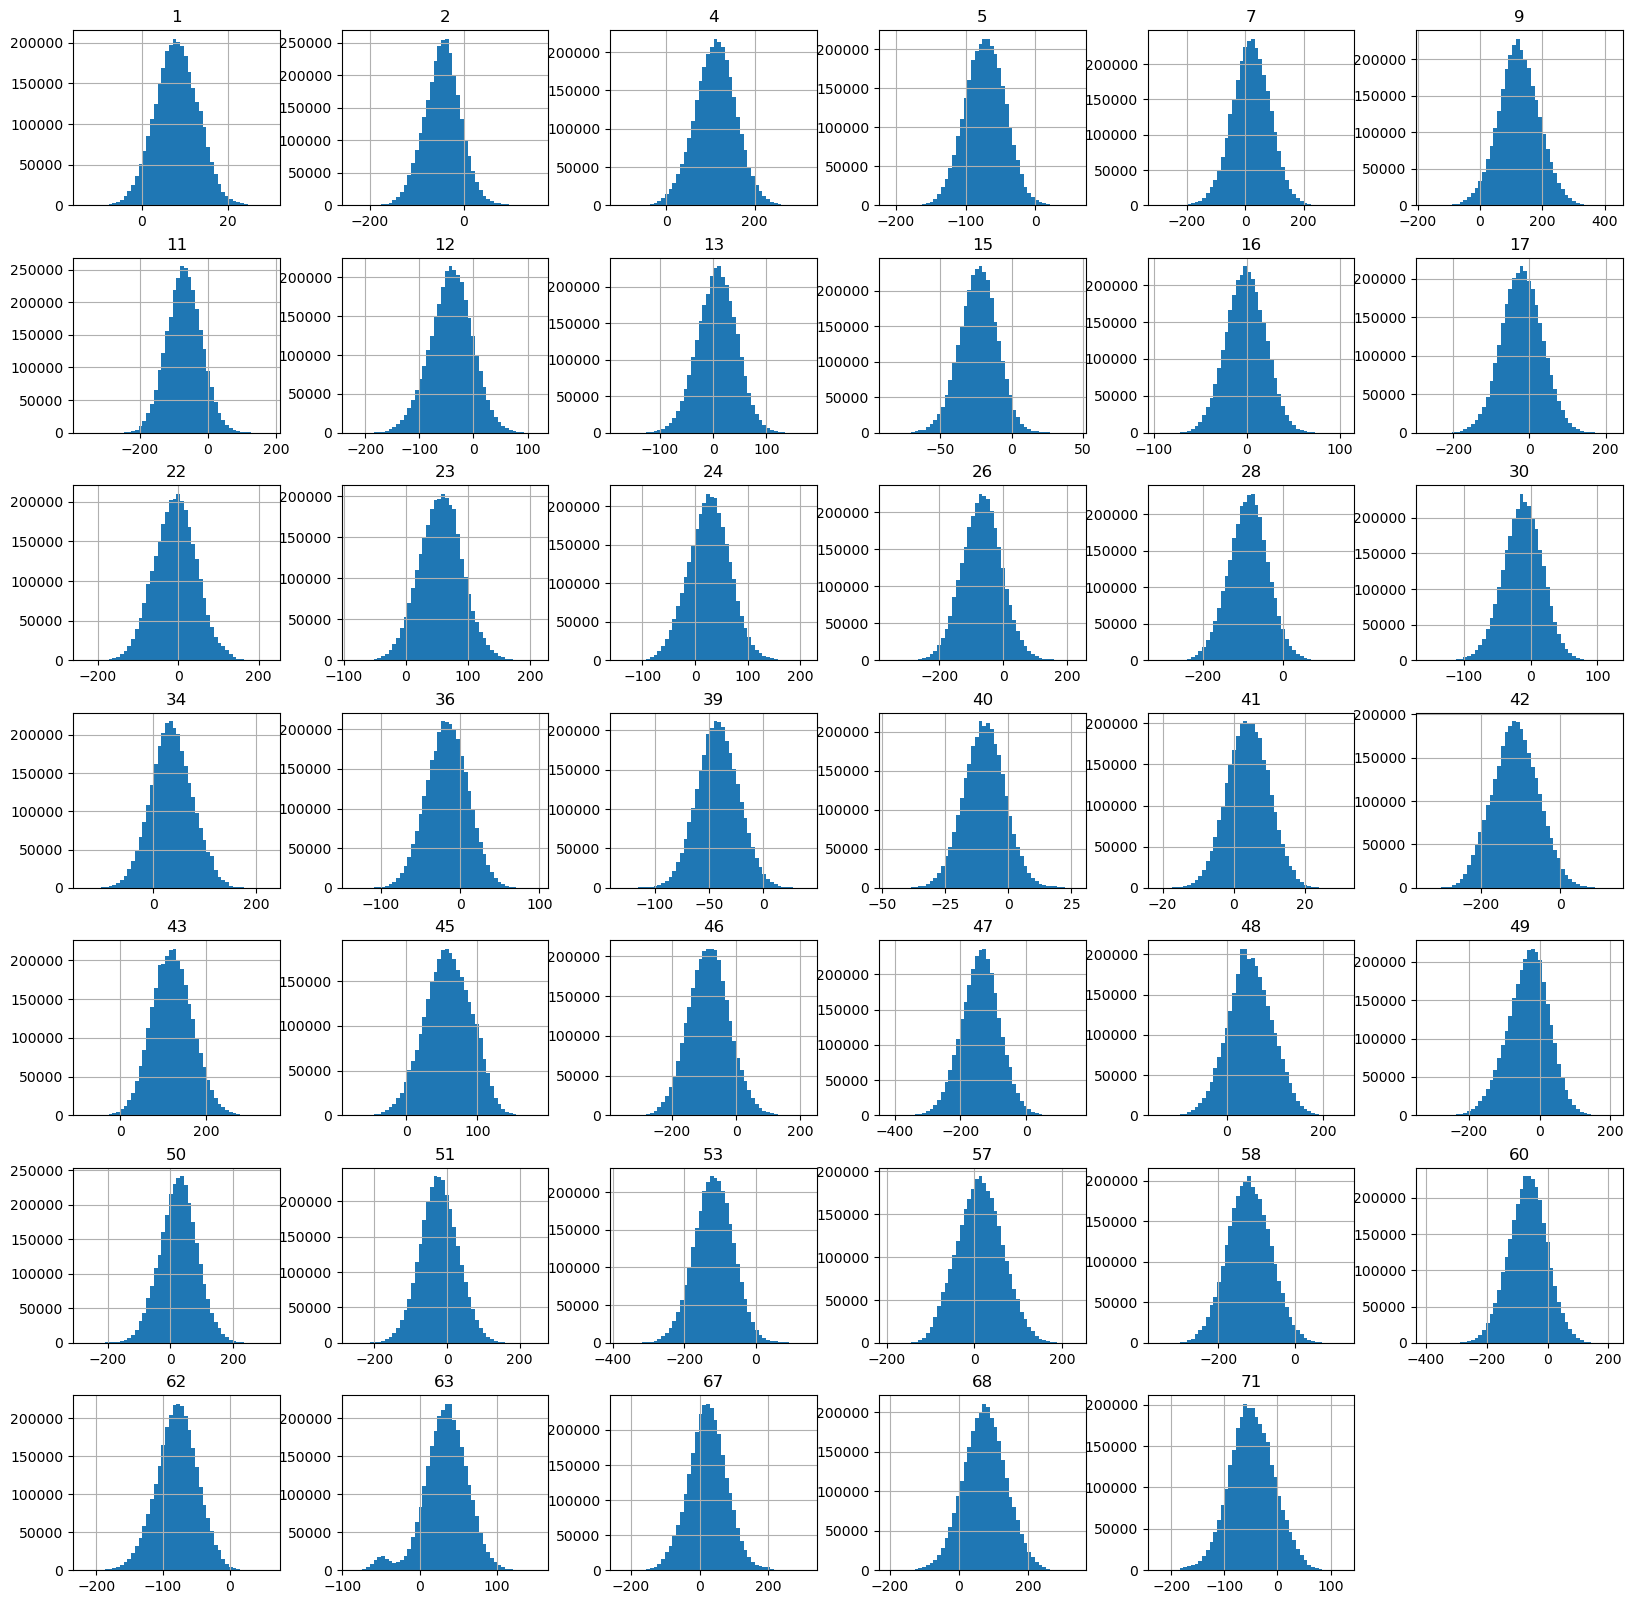

In [109]:
base_vif.hist(figsize=[20, 20], bins=50);

In [85]:
d_vif = base_vif.shape[1]
d_vif

41

In [86]:
target_vif = train_vif['Target']

In [87]:
base_vif_index = {k: v for k, v in enumerate(base_vif.index.to_list())}

In [88]:
index = faiss.IndexFlatL2(d_vif)
index.add(base_vif)

In [89]:
resources = [faiss.StandardGpuResources() for i in range(ngpu)]
index_gpu = faiss.index_cpu_to_gpu_multiple_py(resources, index)

## L2 VIF

In [90]:
%%time
D, I = index_gpu.search(features_t_vif, 5)
acc = 0
for target, el in zip(target_vif.values.tolist(), I.tolist()):
    acc += int(target in [base_vif_index[r] for r in el])

print(100 * acc / len(I))

68.616
CPU times: total: 2.44 s
Wall time: 2.91 s


In [91]:
%%time
D, I = index_gpu.search(valid_vif, 5)
acc = 0
for target, el in zip(targets_v.values.tolist(), I.tolist()):
    acc += int(target in [base_vif_index[r] for r in el])

print(100 * acc / len(I))

68.551
CPU times: total: 2.31 s
Wall time: 2.91 s


## IVF VIF

In [92]:
nlist = 288

quant = faiss.IndexFlatIP(d_vif)
index = faiss.IndexIVFFlat(quant, d_vif, nlist)
index.train(base_vif)
index.add(base_vif)
index.nprobe = 16
resources = [faiss.StandardGpuResources() for i in range(ngpu)]
index_gpu = faiss.index_cpu_to_gpu_multiple_py(resources, index)

In [93]:
%%time
D, I = index_gpu.search(features_t_vif, 5)
acc = 0
for target, el in zip(target_vif.values.tolist(), I.tolist()):
    acc += int(target in [base_vif_index[r] for r in el])

print(100 * acc / len(I))

68.468
CPU times: total: 22.3 s
Wall time: 15.8 s


In [94]:
%%time
D, I = index_gpu.search(valid_vif, 5)
acc = 0
for target, el in zip(targets_v.values.tolist(), I.tolist()):
    acc += int(target in [base_vif_index[r] for r in el])

print(100 * acc / len(I))

68.43
CPU times: total: 22 s
Wall time: 15.5 s


## L2 Scaler VIF

In [95]:
scaler = RobustScaler()
base_slr_vif = scaler.fit_transform(base_vif)
features_slr_vif = scaler.transform(features_t_vif)
valid_slr_vif = scaler.transform(valid_vif)

C:\ProgramData\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and wil

In [96]:
d_vif = base_slr_vif.shape[1]

In [97]:
index = faiss.IndexFlatL2(d_vif)
index.add(base_slr_vif)

In [98]:
resources = [faiss.StandardGpuResources() for i in range(ngpu)]
index_gpu = faiss.index_cpu_to_gpu_multiple_py(resources, index)

In [99]:
base_vif_index = {k: v for k, v in enumerate(base_vif.index.to_list())}

In [100]:
%%time
D, I = index_gpu.search(features_slr_vif, 5)
acc = 0
for target, el in zip(target_vif.values.tolist(), I.tolist()):
    acc += int(target in [base_vif_index[r] for r in el])

print(100 * acc / len(I))

69.796
CPU times: total: 2.12 s
Wall time: 3.2 s


In [101]:
%%time
D, I = index_gpu.search(valid_slr_vif, 5)
acc = 0
for target, el in zip(targets_v.values.tolist(), I.tolist()):
    acc += int(target in [base_vif_index[r] for r in el])

print(100 * acc / len(I))

69.631
CPU times: total: 1.94 s
Wall time: 2.93 s


## IVF Scaler VIF

In [102]:
nlist = 288

quant = faiss.IndexFlatIP(d_vif)
index = faiss.IndexIVFFlat(quant, d_vif, nlist)
index.train(base_slr_vif)
index.add(base_slr_vif)
index.nprobe = 16
resources = [faiss.StandardGpuResources() for i in range(ngpu)]
index_gpu = faiss.index_cpu_to_gpu_multiple_py(resources, index)

In [103]:
%%time
D, I = index_gpu.search(features_slr_vif, 5)
acc = 0
for target, el in zip(target_vif.values.tolist(), I.tolist()):
    acc += int(target in [base_vif_index[r] for r in el])

print(100 * acc / len(I))

69.253
CPU times: total: 4.16 s
Wall time: 3.35 s


In [104]:
%%time
D, I = index_gpu.search(valid_slr_vif, 5)
acc = 0
for target, el in zip(targets_v.values.tolist(), I.tolist()):
    acc += int(target in [base_vif_index[r] for r in el])

print(100 * acc / len(I))

69.088
CPU times: total: 3.56 s
Wall time: 3.07 s
